In [ ]:
%pip install -U lightgbm==3.3.2
# Light Gradient Boosting Machine, is a powerful and efficient gradient boosting framework developed by Microsoft.
# it's designed for distributed and efficient training of large-scale machine learning models

In [ ]:
%pip install implicit
# implicit is a Python library for building and analyzing implicit feedback recommendation systems.
# it provides implementations of collaborative filtering algorithms, including Alternating Least Squares (ALS), Bayesian Personalized Ranking (BPR) and Logistic Matrix Factorization (LMF)
# which are commonly used in recommendation systems to generate recommendations based on implicit feedback (such as user interactions with items)
# by installing the Implicit library, you gain access to these algorithms and can use them to build recommendation systems tailored to your specific use case

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [ ]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
# import modules in Python and configure the IPython interactive shell
# IPython is an enhanced interactive Python interpreter, and it provides features like interactive computing, rich media integration, and support for data visualization
# InteractiveShell is the core class responsible for handling interactive input and output, executing code, and managing user interactions in IPython environments

warnings.filterwarnings("ignore")
sys.path.append("/content/drive/MyDrive/HM-new/")  # path to the 'src' folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [ ]:
from src.data import DataHelper
# imports the DataHelper class from the data module within the src package
# it suggests that there is a module named data within the src package containing a class named DataHelper

from src.data.metrics import map_at_k, hr_at_k, recall_at_k
# imports the map_at_k, hr_at_k, and recall_at_k functions from the metrics module within the data package of the src package

from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
)
# imports multiple classes from the rules module within the retrieval package of the src package

from src.retrieval.collector import RuleCollector
# imports the RuleCollector class from the collector module within the retrieval package of the src package

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale
# imports multiple functions from the features module within the src package
# it imports full_sale, week_sale, repurchase_ratio, popularity, and period_sale functions

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)
# imports multiple functions from the utils module within the src package

In [ ]:
from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
)

from src.retrieval.collector import RuleCollector

In [ ]:
data_dir = Path("/content/drive/MyDrive/HM-new/data/")
model_dir = Path("/content/drive/MyDrive/HM-new/models/")

In [ ]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "Recall"
TEST = True  # Set as `False` when do local experiments to save time

In [ ]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

In [ ]:
dh = DataHelper(data_dir)

In [ ]:
data = dh.preprocess_data(save=True, name="encoded_full")  # run only once, processed data will be saved
# preprocesses the data using the preprocess_data method of the DataHelper class, saves the processed data to disk and assigns the processed data to the variable data
# it's mentioned that this operation should be run only once, as the processed data will be saved and can be reused in subsequent executions

Encode Item Sparse Feats: 100%|██████████| 12/12 [00:00<00:00, 16.90it/s]


In [ ]:
data = dh.load_data(name="encoded_full")
# loads the data named "encoded_full" using the load_data method of the DataHelper class and assigns it to the variable data

In [ ]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [ ]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [ ]:
# WEEK_NUM = 0: test
# WEEK_NUM = 1: valid
# WEEK_NUM > 1: train
for week in range(1,WEEK_NUM):
    # use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]

    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
            SaleTrend(customer_list, train, days=7, n=50),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )

    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules:   6%|▋         | 1/16 [00:16<04:12, 16.85s/it]

Positive rate: 0.03038


Retrieve items by rules:  12%|█▎        | 2/16 [00:34<04:03, 17.37s/it]

Positive rate: 0.02859


Retrieve items by rules:  19%|█▉        | 3/16 [01:25<07:03, 32.60s/it]

Positive rate: 0.01413
Positive rate: 0.01295


Retrieve items by rules:  25%|██▌       | 4/16 [02:16<07:57, 39.76s/it]

Positive rate: 0.01515


Retrieve items by rules:  31%|███▏      | 5/16 [02:35<05:55, 32.27s/it]

Positive rate: 0.01464


Retrieve items by rules:  38%|███▊      | 6/16 [02:56<04:45, 28.59s/it]

Positive rate: 0.00906


Retrieve items by rules:  44%|████▍     | 7/16 [03:28<04:28, 29.79s/it]

Positive rate: 0.00854


Retrieve items by rules:  50%|█████     | 8/16 [04:11<04:30, 33.83s/it]

TOP15.0 Positive rate: 0.00602


Retrieve items by rules:  56%|█████▋    | 9/16 [04:16<02:54, 24.86s/it]

TOP20.5 Positive rate: 0.00608


Retrieve items by rules:  62%|██████▎   | 10/16 [04:21<01:52, 18.67s/it]

TOP2.0 Positive rate: 0.00652


Retrieve items by rules:  69%|██████▉   | 11/16 [04:31<01:19, 15.98s/it]

TOP9.0 Positive rate: 0.00631


Retrieve items by rules:  75%|███████▌  | 12/16 [04:35<00:50, 12.58s/it]

TOP16.0 Positive rate: 0.00601


Retrieve items by rules:  81%|████████▏ | 13/16 [04:40<00:30, 10.21s/it]

TOP12.0 Positive rate: 0.00607


Retrieve items by rules:  88%|████████▊ | 14/16 [05:05<00:29, 14.69s/it]

TOP8.0 Positive rate: 0.00616


Retrieve items by rules:  94%|█████████▍| 15/16 [05:29<00:17, 17.44s/it]

TOP2.0 Positive rate: 0.00758


Retrieve items by rules: 100%|██████████| 16/16 [05:38<00:00, 21.16s/it]


Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules:   6%|▋         | 1/16 [00:17<04:15, 17.02s/it]

Positive rate: 0.03008


Retrieve items by rules:  12%|█▎        | 2/16 [00:34<04:01, 17.26s/it]

Positive rate: 0.02825


Retrieve items by rules:  19%|█▉        | 3/16 [01:24<06:59, 32.25s/it]

Positive rate: 0.01354
Positive rate: 0.01244


Retrieve items by rules:  25%|██▌       | 4/16 [02:13<07:47, 38.99s/it]

Positive rate: 0.01429


Retrieve items by rules:  31%|███▏      | 5/16 [02:33<05:51, 31.97s/it]

Positive rate: 0.01378


Retrieve items by rules:  38%|███▊      | 6/16 [02:55<04:45, 28.54s/it]

Positive rate: 0.00886


Retrieve items by rules:  44%|████▍     | 7/16 [03:26<04:23, 29.31s/it]

Positive rate: 0.00828


Retrieve items by rules:  50%|█████     | 8/16 [04:13<04:40, 35.07s/it]

TOP10.0 Positive rate: 0.00610


Retrieve items by rules:  56%|█████▋    | 9/16 [04:18<03:00, 25.80s/it]

TOP7.0 Positive rate: 0.00611


Retrieve items by rules:  69%|██████▉   | 11/16 [04:33<01:21, 16.38s/it]

skip


Retrieve items by rules:  75%|███████▌  | 12/16 [04:37<00:50, 12.73s/it]

skip


Retrieve items by rules:  81%|████████▏ | 13/16 [04:42<00:30, 10.15s/it]

skip
TOP6.0 Positive rate: 0.00606


Retrieve items by rules:  88%|████████▊ | 14/16 [05:07<00:29, 14.70s/it]

TOP7.0 Positive rate: 0.00603


Retrieve items by rules: 100%|██████████| 16/16 [05:39<00:00, 21.23s/it]

skip


Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules:   6%|▋         | 1/16 [00:15<03:59, 15.94s/it]

Positive rate: 0.02822


Retrieve items by rules:  12%|█▎        | 2/16 [00:32<03:51, 16.55s/it]

Positive rate: 0.02679


Retrieve items by rules:  19%|█▉        | 3/16 [01:22<06:50, 31.57s/it]

Positive rate: 0.01321
Positive rate: 0.01237


Retrieve items by rules:  25%|██▌       | 4/16 [02:09<07:33, 37.83s/it]

Positive rate: 0.01474


Retrieve items by rules:  31%|███▏      | 5/16 [02:28<05:40, 30.99s/it]

Positive rate: 0.01441


Retrieve items by rules:  38%|███▊      | 6/16 [02:47<04:27, 26.73s/it]

Positive rate: 0.00909


Retrieve items by rules:  44%|████▍     | 7/16 [03:21<04:21, 29.09s/it]

Positive rate: 0.00871


Retrieve items by rules:  50%|█████     | 8/16 [04:06<04:35, 34.40s/it]

TOP16.0 Positive rate: 0.00601


Retrieve items by rules:  56%|█████▋    | 9/16 [04:12<02:57, 25.37s/it]

TOP10.5 Positive rate: 0.00612


Retrieve items by rules:  69%|██████▉   | 11/16 [04:26<01:20, 16.16s/it]

skip
TOP11.0 Positive rate: 0.00619


Retrieve items by rules:  75%|███████▌  | 12/16 [04:31<00:50, 12.72s/it]

TOP9.0 Positive rate: 0.00619


Retrieve items by rules:  81%|████████▏ | 13/16 [04:36<00:31, 10.35s/it]

TOP10.0 Positive rate: 0.00601


Retrieve items by rules:  88%|████████▊ | 14/16 [05:01<00:29, 14.76s/it]

TOP9.0 Positive rate: 0.00622


Retrieve items by rules: 100%|██████████| 16/16 [05:32<00:00, 20.81s/it]

skip


Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules:   6%|▋         | 1/16 [00:15<03:58, 15.89s/it]

Positive rate: 0.02406


Retrieve items by rules:  12%|█▎        | 2/16 [00:32<03:49, 16.37s/it]

Positive rate: 0.02268


Retrieve items by rules:  19%|█▉        | 3/16 [01:20<06:41, 30.88s/it]

Positive rate: 0.01182
Positive rate: 0.01123


Retrieve items by rules:  25%|██▌       | 4/16 [02:08<07:30, 37.57s/it]

Positive rate: 0.01345


Retrieve items by rules:  31%|███▏      | 5/16 [02:25<05:31, 30.12s/it]

Positive rate: 0.01310


Retrieve items by rules:  38%|███▊      | 6/16 [02:46<04:31, 27.12s/it]

Positive rate: 0.00878


Retrieve items by rules:  44%|████▍     | 7/16 [03:25<04:38, 30.89s/it]

Positive rate: 0.00839


Retrieve items by rules:  50%|█████     | 8/16 [04:18<05:04, 38.01s/it]

TOP13.0 Positive rate: 0.00603


Retrieve items by rules:  56%|█████▋    | 9/16 [04:24<03:14, 27.81s/it]

TOP14.5 Positive rate: 0.00606


Retrieve items by rules:  69%|██████▉   | 11/16 [04:38<01:26, 17.39s/it]

skip
TOP5.0 Positive rate: 0.00631


Retrieve items by rules:  75%|███████▌  | 12/16 [04:43<00:54, 13.57s/it]

TOP8.0 Positive rate: 0.00650


Retrieve items by rules:  81%|████████▏ | 13/16 [04:48<00:32, 10.98s/it]

TOP7.0 Positive rate: 0.00607


Retrieve items by rules:  88%|████████▊ | 14/16 [05:13<00:30, 15.13s/it]

TOP3.0 Positive rate: 0.00660


Retrieve items by rules: 100%|██████████| 16/16 [05:44<00:00, 21.56s/it]

skip


Week 5: [2020-08-19, 2020-08-26)


Retrieve items by rules:   6%|▋         | 1/16 [00:15<03:53, 15.54s/it]

Positive rate: 0.02329


Retrieve items by rules:  12%|█▎        | 2/16 [00:31<03:40, 15.78s/it]

Positive rate: 0.02211


Retrieve items by rules:  19%|█▉        | 3/16 [01:20<06:43, 31.02s/it]

Positive rate: 0.01187
Positive rate: 0.01101


Retrieve items by rules:  25%|██▌       | 4/16 [02:09<07:34, 37.87s/it]

Positive rate: 0.01309


Retrieve items by rules:  31%|███▏      | 5/16 [02:28<05:43, 31.23s/it]

Positive rate: 0.01265


Retrieve items by rules:  38%|███▊      | 6/16 [02:48<04:33, 27.39s/it]

Positive rate: 0.00873


Retrieve items by rules:  44%|████▍     | 7/16 [03:25<04:36, 30.68s/it]

Positive rate: 0.00822


Retrieve items by rules:  50%|█████     | 8/16 [04:15<04:54, 36.75s/it]

TOP2.5 Positive rate: 0.00600


Retrieve items by rules:  56%|█████▋    | 9/16 [04:19<03:04, 26.38s/it]

TOP8.5 Positive rate: 0.00605


Retrieve items by rules:  69%|██████▉   | 11/16 [04:32<01:21, 16.28s/it]

skip
TOP2.0 Positive rate: 0.00657


Retrieve items by rules:  81%|████████▏ | 13/16 [04:39<00:29,  9.73s/it]

skip
TOP1.0 Positive rate: 0.00644


Retrieve items by rules:  94%|█████████▍| 15/16 [05:24<00:16, 16.12s/it]

skip


Retrieve items by rules: 100%|██████████| 16/16 [05:32<00:00, 20.78s/it]

skip


In [ ]:
# use the threshold in week 1 to generate candidates for test data, see the log in the upper cell
if TEST:
    week = 0
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]

    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    customer_list = submission['customer_id'].values

    # ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=15, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=20.5, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=2),
            TimeHistory(customer_list, last_week, n=9, name='1'),
            TimeHistory(customer_list, last_3days, n=16, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=12, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=8, name='2'),
            SaleTrend(customer_list, train, days=7, n=2),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )

    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 16/16 [05:34<00:00, 20.92s/it]


In [ ]:
# ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            TimeHistory(customer_list, last_week, n=9, name='1'),
            TimeHistory(customer_list, last_3days, n=16, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=12, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=8, name='2'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=15, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=20, name='2'),
            SaleTrend(customer_list, train, days=7, n=2),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=2),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )

In [ ]:
del train, valid, last_week, customer_list, candidates
gc.collect()
# clear up memory usage by deleting variables and collecting garbage

30

## Feature engineering


In [ ]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [ ]:
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [ ]:
# merge full candidates to transaction data (avoid feature missing in training data)
full_candidates = []
for i in tqdm(range(WEEK_NUM)):
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    full_candidates += candidate['article_id'].values.tolist()
full_candidates = list(set(full_candidates))
del candidate
gc.collect()

num_candidates = len(full_candidates)
full_candidates = np.array(full_candidates)
full_candidates = np.tile(full_candidates, WEEK_NUM + 1)
weeks = np.repeat(np.arange(1,WEEK_NUM+2), num_candidates)
full_candidates = pd.DataFrame({'article_id':full_candidates, 'week':weeks})

inter['valid'] = 1
in_train = inter[inter['week']<=WEEK_NUM + 1]
out_train = inter[inter['week']>WEEK_NUM + 1]

in_train = in_train.merge(full_candidates, on=['article_id','week'], how='right')
in_train['valid'] = in_train['valid'].fillna(0)
inter = pd.concat([in_train, out_train], ignore_index=True)
inter = inter.sort_values(["valid"], ascending=False).reset_index(drop=True)

100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


0

In [ ]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# merges the product_code information from the item DataFrame into the inter DataFrame based on the common column article_id
# after this operation, the inter DataFrame will have an additional column product_code, containing the corresponding product codes for each article ID

In [ ]:
inter.shape

(31837313, 8)

In [ ]:
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)

In [ ]:
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)

In [ ]:
inter.shape

(31837313, 30)

In [ ]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'], week_num=WEEK_NUM)

100%|██████████| 6/6 [02:20<00:00, 23.42s/it]


In [ ]:
inter.shape

(31837313, 32)

In [ ]:
inter, _ = reduce_mem_usage(inter)
# reduces the memory usage of the DataFrame inter using the reduce_mem_usage function

In [ ]:
inter["i_sale"] = week_sale(inter, ["article_id"], week_num=WEEK_NUM)
inter["p_sale"] = week_sale(inter, ["product_code"], week_num=WEEK_NUM)
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True, week_num=WEEK_NUM)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True, week_num=WEEK_NUM)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1, week_num=WEEK_NUM) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1, week_num=WEEK_NUM)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1, week_num=WEEK_NUM)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1, week_num=WEEK_NUM)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    # "product_group_name",
    # "graphical_appearance_no",
    # "colour_group_code",
    # "perceived_colour_value_id",
    # "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale", week_num=WEEK_NUM)
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1, week_num=WEEK_NUM)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

100%|██████████| 1/1 [00:11<00:00, 11.05s/it]


In [ ]:
inter.shape

(31837313, 54)

In [ ]:
# Date related
curr_date_dict = {x:calc_valid_date(x-1)[0] for x in range(100)}
current_dat = inter['week'].map(curr_date_dict)
mask = inter['valid']==0
inter.loc[mask, 't_dat'] = inter.loc[mask, 'week'].map(curr_date_dict)
first_date = inter.groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
inter = pd.merge(inter, first_date, on='article_id', how='left')
# df = pd.merge(df, last_date, on='article_id', how='left')
inter['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(inter['first_dat'])).dt.days

In [ ]:
inter.shape

(31837313, 55)

In [ ]:
inter['i_full_sale'] = full_sale(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_full_sale'] = full_sale(inter, ['product_code'], week_num=WEEK_NUM)

inter['i_daily_sale'] = inter['i_full_sale'] / inter['first_dat']
inter['p_daily_sale'] = inter['p_full_sale'] / inter['first_dat']
inter['i_daily_sale_ratio'] = inter['i_daily_sale'] / inter['p_daily_sale']
inter['i_w_full_sale_ratio'] = inter['i_sale'] / inter['i_full_sale']

inter['i_2w_full_sale_ratio'] = inter['i_2w_sale'] / inter['i_full_sale']
inter['p_w_full_sale_ratio'] = inter['p_sale'] / inter['p_full_sale']
inter['p_2w_full_sale_ratio'] = inter['p_2w_sale'] / inter['p_full_sale']

inter['i_week_above_daily_sale'] = inter['i_sale'] / 7 - inter['i_daily_sale']
inter['p_week_above_full_sale'] = inter['p_sale'] / 7 - inter['i_full_sale']
inter['i_2w_week_above_daily_sale'] = inter['i_2w_sale'] / 14 - inter['i_daily_sale']
inter['p_2w_week_above_daily_sale'] = inter['p_2w_sale'] / 14 - inter['p_daily_sale']

In [ ]:
gc.collect()

0

In [ ]:
for f in tqdm(item_feats):
    inter[f'{f}_full_sale'] = full_sale(inter, [f], week_num=WEEK_NUM)
    f_first_date = inter.groupby(f)['t_dat'].min().reset_index(name=f'{f}_first_dat')
    inter = inter.merge(f_first_date, on=f, how='left')
    inter[f'{f}_daily_sale'] = inter[f'{f}_full_sale'] / (pd.to_datetime(current_dat) - pd.to_datetime(inter[f'{f}_first_dat'])).dt.days
    inter[f'i_{f}_daily_sale_ratio'] = inter['i_daily_sale'] / inter[f'{f}_daily_sale']
    inter[f'p_{f}_daily_sale_ratio'] = inter['p_daily_sale'] / inter[f'{f}_daily_sale']
    del inter[f'{f}_full_sale'], inter[f'{f}_first_dat']
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

21

100%|██████████| 1/1 [00:35<00:00, 35.09s/it]


In [ ]:
for f in item_feats + ['i_full_sale','p_full_sale']:
    del inter[f]
# this code block deletes the columns specified in the `item_feats` list along with `i_full_sale` and `p_full_sale` from the `inter` DataFrame.
# this step is likely taken to clean up unnecessary columns and optimize memory usage after the feature engineering process.

In [ ]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)
# the code adds two new columns to the `inter` DataFrame, namely `i_pop` and `p_pop`, which represent the popularity of items and product codes, respectively
# the popularity is calculated based on the number of occurrences of each item or product code within the specified time window, which is determined by the `week_num` parameter

In [ ]:
inter = inter.loc[inter['week'] <= WEEK_NUM + 2]
# filters the inter DataFrame to include only rows where the week number is less than or equal to WEEK_NUM + 2
# adding two more weeks to WEEK_NUM extends the analysis or processing for an additional two weeks beyond the original duration specified by WEEK_NUM

In [ ]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")
# saves the DataFrame inter to a Parquet file named "processed_inter.pqt" in the specified data directory
# parquet is a columnar storage file format, often used in big data processing frameworks like Apache Spark

## Merge Features


In [ ]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
inter = inter[inter['week'] <= WEEK_NUM + 2]
# reads the processed DataFrame inter from the Parquet file "processed_inter.pqt" located in the specified data directory
# it then filters the DataFrame to include only rows where the week number (week) is less than or equal to the value of WEEK_NUM + 2.

In [ ]:
# embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)
# embeddings from Word2Vector model
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)

In [ ]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])

In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    if i == 0:
        chunk_size = int(candidate.shape[0] * 0.5)
        for chunk,batch in enumerate(range(0, candidate.shape[0], chunk_size)):
            sub_candidate = candidate.iloc[batch:batch+chunk_size-1]
            # * merge features
            sub_candidate = merge_week_data(data, inter, i, sub_candidate)
            sub_candidate['article_id'] = sub_candidate['article_id'].astype(int)
            sub_candidate['customer_id'] = sub_candidate['customer_id'].astype(int)
            # * merge DSSM user and item embeddings
            sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
            # * merge YouTubeDNN user and item embeddings
            sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
            # * merge Word2Vector user and item embeddings
            sub_candidate["wv_similarity"] = calc_embd_similarity(sub_candidate, w2v_user_embd, w2v_item_embd, sub=False)
            print(f"Chunk {chunk} done...")
            sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{chunk}.pqt")
    else:
        # * merge features
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
        candidate["wv_similarity"] = calc_embd_similarity(candidate, w2v_user_embd, w2v_item_embd, sub=False)
    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

Chunk 0 done...


  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

Chunk 1 done...


 17%|█▋        | 1/6 [06:22<31:51, 382.28s/it]

68984
[1]


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [06:49<11:34, 173.68s/it]

72019
[2]


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

 50%|█████     | 3/6 [07:20<05:24, 108.33s/it]

75822
[3]


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [07:47<02:32, 76.27s/it] 

80253
[4]


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [08:13<00:58, 58.26s/it]

72035
[5]


  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

100%|██████████| 6/6 [08:40<00:00, 86.69s/it]


In [ ]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

144

## Ranking


In [ ]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


In [ ]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
    "user_gender",
    "article_gender",
    "season_type"
]

In [ ]:
# Convert categorical featues as `CategoricalDtype`
cate_dict = {}
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:03<00:00,  5.39it/s]


In [ ]:
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

### Extra Features

In [ ]:
inter = data['inter']
inter = inter[inter['t_dat']<'2020-08-19']   # start date of the last valid week
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")

In [ ]:
tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

In [ ]:
feats += [
    'article_time_mean',
    'customer_id_last_time',
    'customer_id_first_time',
    'customer_id_time_mean',
    'customer_id_gap'
]

# this code adds the newly created temporal features to the list of features `feats`. These features will be used in subsequent modeling steps

In [ ]:
del tmp
gc.collect()

27

### Train


In [ ]:
for feat in tqdm(cat_features):
    full_data[feat] = full_data[feat].astype(cate_dict[feat])

# this code converts the categorical features in `full_data` to the specified categorical data type (`CategoricalDtype`) using the dictionary `cate_dict` created earlier
# this is done to optimize memory usage and speed up certain operations when working with categorical data

100%|██████████| 17/17 [00:01<00:00, 10.24it/s]


In [ ]:
train = full_data.loc[full_data['week']>1]
valid = full_data.loc[full_data['week']==1]

del full_data
gc.collect()

# separates the `full_data` into `train` and `valid` sets based on the week column.
# specifically, it selects rows where the week is greater than 1 for the training set (`train`) and where the week is equal to 1 for the validation set (`valid`).
# finally, it deletes the `full_data` dataframe from memory and performs garbage collection to free up memory.

0

In [ ]:
params = {
    "objective": "lambdarank",   # Objective for ranking
    "boosting_type": "gbdt",     # Gradient Boosting Decision Tree
    "metric": "map",             # Evaluation metric: Mean Average Precision
    "max_depth": 8,              # Maximum tree depth for base learners
    "num_leaves": 125,           # Maximum number of leaves in one tree
    "learning_rate": 0.03,       # Learning rate
    "verbose": -1,               # Suppress output
    "eval_at": [12],             # Evaluate at position 12
}

In [ ]:
def train_rank_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
# del candidates
# gc.collect()

0

In [ ]:
print("Train positive rate:", train.label.mean())

Train positive rate: 0.006699889195867354


In [ ]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [ ]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int32")  # convert to int to avoid `0` in groupby count result
train_group = (train_group.groupby(["week", "customer_id"]).size().values)

In [ ]:
valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int32")  # convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"]).size().values

In [ ]:
train = train[feats+['label']]
valid = valid[feats+['label']]

# these lines of code select only the features (`feats`) and the target variable (`label`) from the `train` and `valid` DataFrames, discarding all other columns.
# this is done to prepare the data for model training, ensuring that only relevant features and the target variable are used in the training and validation processes.

In [ ]:
# gc.collect()

0

In [ ]:
ranker = train_rank_model(train, valid, train_group, valid_group)

Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.705006
[20]	valid_0's auc: 0.710615
[30]	valid_0's auc: 0.715143
[40]	valid_0's auc: 0.716532
[50]	valid_0's auc: 0.715625
[60]	valid_0's auc: 0.716351
[70]	valid_0's auc: 0.717111
[80]	valid_0's auc: 0.718056
[90]	valid_0's auc: 0.719275
[100]	valid_0's auc: 0.719707
[110]	valid_0's auc: 0.721029
[120]	valid_0's auc: 0.721052
[130]	valid_0's auc: 0.721383
[140]	valid_0's auc: 0.721723
[150]	valid_0's auc: 0.721636
[160]	valid_0's auc: 0.721851
[170]	valid_0's auc: 0.722054
[180]	valid_0's auc: 0.721705
[190]	valid_0's auc: 0.721793
[200]	valid_0's auc: 0.721595
Early stopping, best iteration is:
[170]	valid_0's auc: 0.722054


### Inference

In [ ]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker.model")

<Figure size 800x2200 with 0 Axes>

<Axes: xlabel='importance', ylabel='feature'>

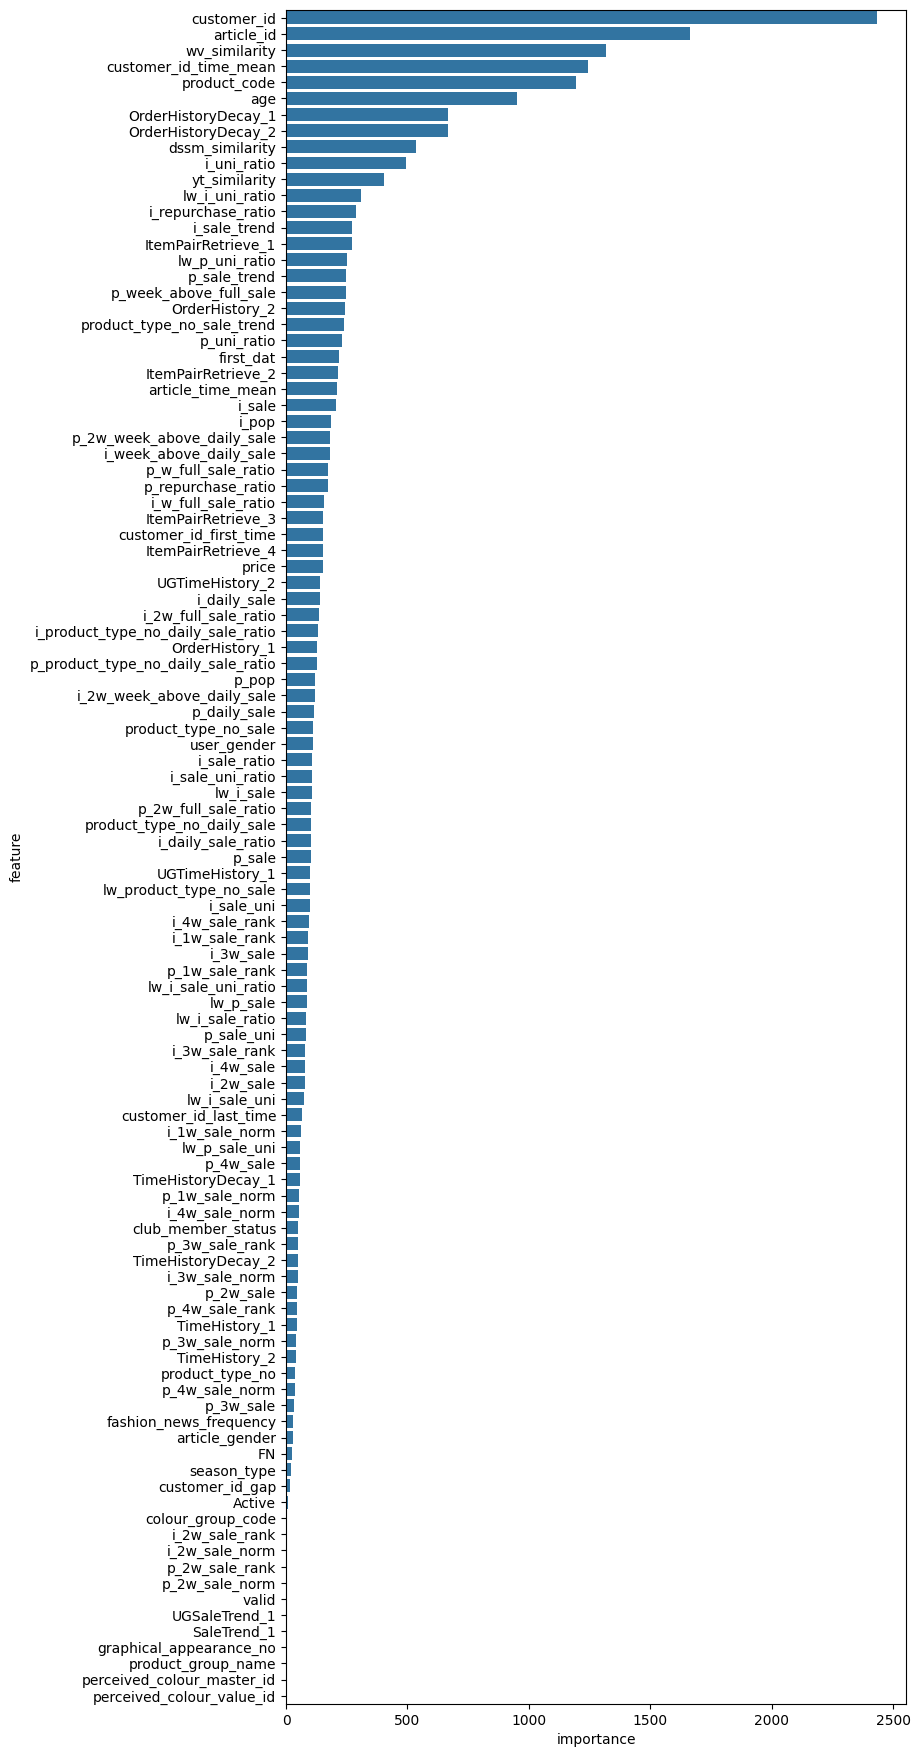

In [ ]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 22))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [ ]:
val_candidates = valid.reset_index(drop=True)
# creates a new DataFrame named val_candidates by resetting the index of the DataFrame valid and dropping the original index

In [ ]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [ ]:
pred = predict(ranker, val_candidates)

  0%|          | 0/68984 [00:00<?, ?it/s]

In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)

0.030601812692809552

In [ ]:
batch_size = 5_000_000
probs = np.zeros(val_candidates.shape[0])
for batch in range(0, val_candidates.shape[0], batch_size):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
val_candidates["prob"] = probs
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [ ]:
pred_lgb.to_parquet(data_dir/"processed"/"small_rank_valid.pqt")

### Test

In [ ]:
del candidate
gc.collect()

22

In [ ]:
test_pred = []
for chunk in range(2):
    print(f"Chunk {chunk}")
    test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week0_candidate_{chunk}.pqt")
    for feat in cat_features:
        test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

    # Extra Features ===================================

    tmp = inter.groupby('article_id').week.mean()
    test_candidates['article_time_mean'] = test_candidates['article_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.nth(-1)
    test_candidates['customer_id_last_time'] = test_candidates['customer_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.nth(0)
    test_candidates['customer_id_first_time'] = test_candidates['customer_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.mean()
    test_candidates['customer_id_time_mean'] = test_candidates['customer_id'].map(tmp)

    test_candidates['customer_id_gap'] = test_candidates['customer_id_first_time'] - test_candidates['customer_id_last_time']

    gc.collect()
    # ==================================================

    batch_size = 5_000_000
    probs = np.zeros(test_candidates.shape[0])
    for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
        outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    test_candidates["prob"] = probs
    pred_lgb = test_candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    test_pred.append(pred_lgb)
    del test_candidates
    gc.collect()

Chunk 0


0

100%|██████████| 6/6 [02:09<00:00, 21.56s/it]


4

Chunk 1


0

100%|██████████| 6/6 [02:10<00:00, 21.81s/it]


4

In [ ]:
pred_lgb = pd.concat(test_pred, ignore_index=True)

In [ ]:
pred_lgb.to_parquet(data_dir/"processed"/"lgb_ranker_test.pqt")

# Saves the predictions for the test data into a Parquet file named `"small_rank_test.pqt"` in the "processed" directory of the specified `data_dir`

In [ ]:
pred_lgb.head()